# Beta Shrinkage

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

import numpy as np
import yfinance as yf
import pandas as pd
import bs4 as bs
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


from src.beta import Beta, BetaBMA, BetaForecastCombination
from src.utils import stack_dict_to_df

## Bivariate Example

In [2]:
# pull sample data
start_date = "2020-01-01"
end_date = "2022-01-01"

sample_data = yf.download("AAPL SPY", start=start_date, end=end_date, progress=False)["Adj Close"]
sample_returns = sample_data.pct_change().dropna()
sample_returns.index = pd.DatetimeIndex(sample_returns.index)

In [3]:
bivar_beta = Beta(sample_returns["SPY"], sample_returns["AAPL"])
benchmark = sample_returns.cov().iloc[0,1] / sample_returns["SPY"].var()
ols_classic = bivar_beta.ols(False)
ols_adj = bivar_beta.ols(True)
vasicek = bivar_beta.vasicek()
welch_classic = bivar_beta.welch()
welch_aged = bivar_beta.welch(rho=2/256)
robeco = bivar_beta.robeco(0.5, 2)
scholes_williams = bivar_beta.scholes_williams()

report = """
    Beta Calculation Methods
    ------------------------
    Benchmark: {:.4f}
    Classic OLS: {:.4f}
    Adjusted OLS: {:.4f}
    Vasicek: {:.4f}
    Welch: {:.4f}
    Welch (aged): {:.4f}
    Robeco: {:.4f}
    Scholes-Williams: {:.4f}
    
""".format(benchmark, ols_classic, ols_adj, vasicek, welch_classic, welch_aged, robeco, scholes_williams)
print(report)


    Beta Calculation Methods
    ------------------------
    Benchmark: 1.1788
    Classic OLS: 1.1788
    Adjusted OLS: 1.1198
    Vasicek: 1.1777
    Welch: 1.1771
    Welch (aged): 1.2292
    Robeco: 1.0267
    Scholes-Williams: 0.9329
    



## Cross-Sectional Analysis

In [4]:
%%capture
# scrape index constituents using beautifulsoup4
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = [row.findAll('td')[0].text for row in table.findAll('tr')[1:]]
tickers = [s.replace('\n', '') for s in tickers] + ["SPY"]

# get data via yahoo finance and calculate daily returns
data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Adj Close"]
member_returns = data.pct_change().iloc[1:,:].dropna(axis=1)
member_returns.index = pd.DatetimeIndex(member_returns.index)
member_returns.index.name = ""

# calculate rolling 1 month beta using textbook definition: corr * vol ratio
corr = member_returns.groupby(pd.Grouper(freq="M")).apply(lambda x: x.corr().loc["SPY",:]).iloc[1:,:]
std_i = member_returns.groupby(pd.Grouper(freq="M")).std().iloc[1:]
std_bm = member_returns[["SPY"]].groupby(pd.Grouper(freq="M")).std().iloc[1:]
beta = corr * (std_i.values / std_bm.values)

# visualise correlation between beta
corr = [scipy.stats.kendalltau(beta.iloc[i-1,:], beta.iloc[i,:])[0] for i in range(1, beta.shape[0])]
pd.DataFrame(corr, index=beta.index[1:]).plot(figsize=(5,3), legend=False, title=r"Kendall's Tau of $\beta_{t-1}$ and $\beta_t$");

In [5]:
# calculate beta for each stock at each cross section
results = {}

for stock in member_returns.drop(columns=["SPY"]).columns:
    returns = member_returns.loc[:,[stock, "SPY"]]
    results[stock] = {}
    for block in returns.groupby(pd.Grouper(freq="M")):
        date, df = block
        if df.shape[0] > 3:
            exog, endog = df["SPY"], df[stock]
            stock_beta = Beta(exog, endog)
            results[stock][date] = {
                "ols": stock_beta.ols(False),
                "ols_adj": stock_beta.ols(True),
                "vasicek": stock_beta.vasicek(),
                "welch": stock_beta.welch(),
                "welch_aged": stock_beta.welch(rho=2/256),
                "robeco": stock_beta.robeco(0.5, 1.2),
                # "scholes_williams": stock_beta.scholes_williams()
            }
            
beta_results = stack_dict_to_df(results)

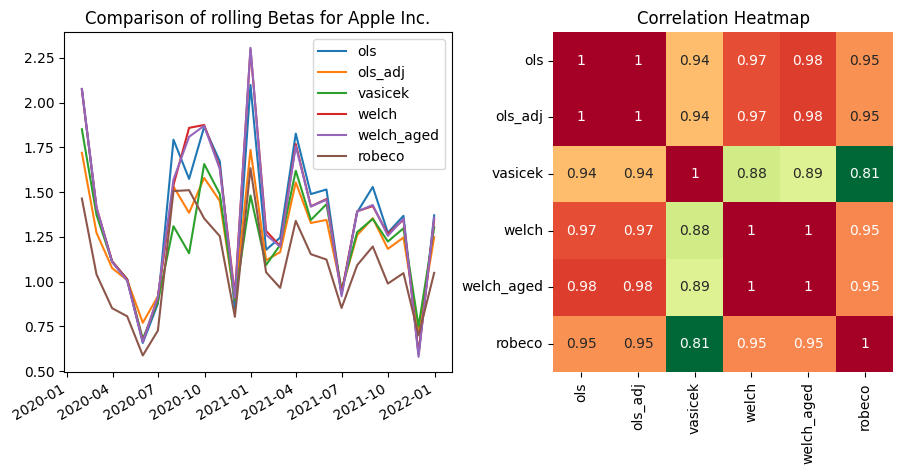

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(11,5))

beta_results["AAPL"].plot(title="Comparison of rolling Betas for Apple Inc.", ax=ax[0])
sns.heatmap(beta_results["AAPL"].corr(), cmap='RdYlGn_r', ax=ax[1], annot=True, cbar=False, square=True)
ax[1].set_title("Correlation Heatmap");

## Forecast Combination

In [8]:
bfc = BetaForecastCombination(sample_data.iloc[:,0], sample_data.iloc[:,1])
bfc.fit()


0.6206449189148003

## Bayesian Model Averaging

In [9]:
bma = BetaBMA(sample_data.iloc[:,0], sample_data.iloc[:,1])
bma.fit()